In [1]:
source("../../R/gen_data.R")
source("../../R/display.R")
source("../../R/metrics.R")
library(JGL)
library(GGMselect)
library(network)
library(intergraph) #convert between network and igraph
library(BDgraph)
library(tmvtnorm)
library(matlab)
library(latex2exp)
library(viridis)
library(abind)

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: mvtnorm

‘network’ 1.17.1 (2021-06-12), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


Attaching package: ‘network’

The following objects are masked from ‘package:igraph’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute


Attaching package: ‘BDgraph’

The following object is masked from ‘package:mvtnorm’:

    rmvnorm

The following object is masked from ‘package:igraph’:

    compare

Loading required p

In [2]:
path <- "../../figures/simple_example/"
ID <- "006"

[1] "Base Graph"


[1] 81.66778

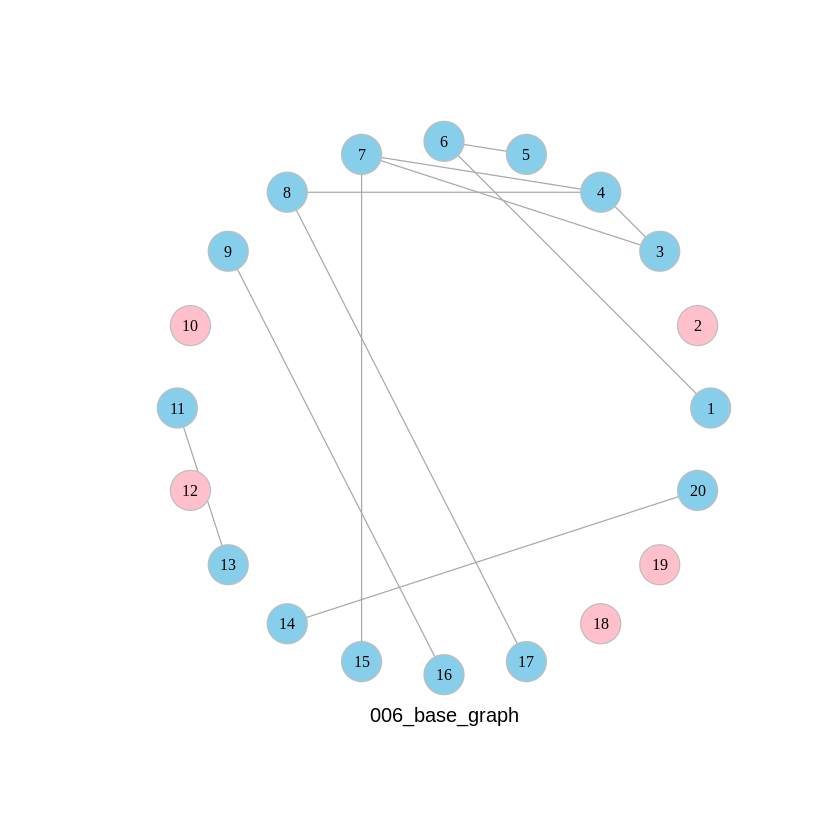

In [4]:
##############################
#     generate base graph    #
#                            #
##############################
set.seed(5)
print("Base Graph")
p=20
# simulate grap
eta=0.2
base_Gr <- gen_baseGraph(p,eta)
base_gV <- network(base_Gr$G, directed=FALSE)
#convert network to igraph
ibase_gV <- asIgraph(base_gV)

plot_igraph(ibase_gV, paste(ID,"_base_graph",sep=""),path=path)
max(abs(solve(base_Gr$C)))

[1] "Graph 1"
[1] 1.638987
[1] "Graph 2"
[1] 1.261852
[1] "Graph 3"
[1] 1.392
[1] "Graph 4"
[1] 1.637721


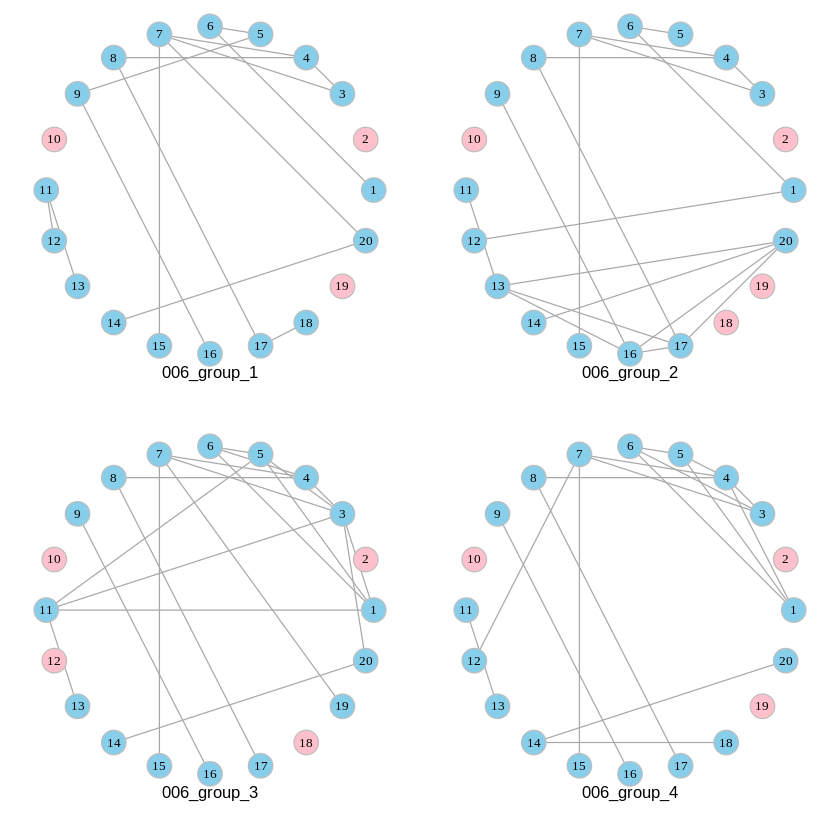

In [6]:
##############################
#       generate groups      #
#                            #
##############################
set.seed(10)
p=20
n=80
eta=0.05
g_num = 4
par(mfrow=c(2,2), mar = c(2., 0., 0., 0.)) 
data <- list()
graph <- list()
for (i in 1:g_num){
    print(paste("Graph",i))
    
    #simulate graph and data
    group_i <- gen_groupGraph(n,p,eta,base_Gr)
    #constuct network
    gVi <- network(group_i$Gr$G, directed=FALSE)
    #convert network to igraph
    i_gVi <- asIgraph(gVi)
    
    plot_igraph(i_gVi,title=paste(ID,"_group_",i,sep=""),line_placement=-19,path=path)
    graph[i] <- list(list("igraph"=i_gVi, "ggm"=group_i$Gr))
    data[i] <-list(group_i$X)
    print(max(abs(solve(group_i$Gr$C))))
}


In [7]:
print("##################################################")
print("#             Fused Graphical Lasso              #")
print("##################################################")
fgl.results=JGL(Y=data,penalty="fused",lambda1=.05,lambda2=.2, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(fgl.results, graph, p, g_num)))
print(paste("Average frobenious loss:", frobenious_loss(fgl.results, graph, g_num)))
print(paste("Average false positive rate:", avg_fprfnr(fgl.results, graph, g_num)[1]))
print(paste("Average false negative rate:", avg_fprfnr(fgl.results, graph, g_num)[2]))
#show_result(fgl.results, graph, 4)

[1] "##################################################"
[1] "#             Fused Graphical Lasso              #"
[1] "##################################################"
[1] "Average entropy loss: 0.848225435317666"
[1] "Average frobenious loss: 0.0934674437849614"
[1] "Average false positive rate: 0.310453633367246"
[1] "Average false negative rate: 0.402941176470588"


In [8]:
print("##################################################")
print("#            Group Graphical Lasso               #")
print("##################################################")
ggl.results=JGL(Y=data,penalty="group",lambda1=.05,lambda2=.1, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(ggl.results, graph, p, g_num)))
print(paste("Average frobenious loss:", frobenious_loss(ggl.results, graph, g_num)))
print(paste("Average false positive rate:", avg_fprfnr(ggl.results, graph, g_num)[1]))
print(paste("Average false negative rate:", avg_fprfnr(ggl.results, graph, g_num)[2]))
#show_result(ggl.results, graph, 4, method="group")

[1] "##################################################"
[1] "#            Group Graphical Lasso               #"
[1] "##################################################"
[1] "Average entropy loss: 0.788649306168988"
[1] "Average frobenious loss: 0.0609467823571717"
[1] "Average false positive rate: 0.403821347316328"
[1] "Average false negative rate: 0.267728758169935"


In [9]:
print("##################################################")
print("#                Graphical Lasso                 #")
print("##################################################")
gl.results=JGL(Y=data,penalty="group",lambda1=.05,lambda2=.0, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(gl.results, graph, p, g_num)))
print(paste("Average frobenious loss:", frobenious_loss(gl.results, graph, g_num)))
print(paste("Average false positive rate:", avg_fprfnr(gl.results, graph, g_num)[1]))
print(paste("Average false negative rate:", avg_fprfnr(gl.results, graph, g_num)[2]))
#show_result(gl.results, graph, 4, method="gl")

[1] "##################################################"
[1] "#                Graphical Lasso                 #"
[1] "##################################################"
[1] "Average entropy loss: 1.49235691910426"
[1] "Average frobenious loss: 0.133437060114839"
[1] "Average false positive rate: 0.554508593624356"
[1] "Average false negative rate: 0.234150326797386"


In [10]:
##############################
#     Different lambda 1     #
#     Test on all methods    #
##############################
lambda.eff <- seq(0.01, 0.3, len = 30)

el_vec <- matrix(NA,3, length(lambda.eff))
fr_vec <- matrix(NA,3, length(lambda.eff))
fpr_vec <- matrix(NA,3, length(lambda.eff))
fnr_vec <- matrix(NA,3, length(lambda.eff))
#sse_vec <- matrix(NA,3, length(lambda.eff))
for(i in 1:length(lambda.eff)){
	fit <-list()
    fit[1] <- list(JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=.2, return.whole.theta=TRUE)) 
    fit[2] <- list(JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=.1, return.whole.theta=TRUE)) 
    fit[3] <- list(JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=.0, return.whole.theta=TRUE)) 

    for(j in 1:3){
        fpr_vec[j,i] <-avg_fprfnr(fit[[j]], graph, 2)[1]
        fnr_vec[j,i] <- avg_fprfnr(fit[[j]], graph, 2)[2]
        el_vec[j,i] <- entropy_loss(fit[[j]], graph, p, 2)
        fr_vec[j,i] <- frobenious_loss(fit[[j]], graph, 2)
        #sse_vec[j,i] <- sum_of_squared_error(fit[[j]], graph, 4)
    }

}
#sse_vec <- sse_vec / 4

png 
  3

png 
  2

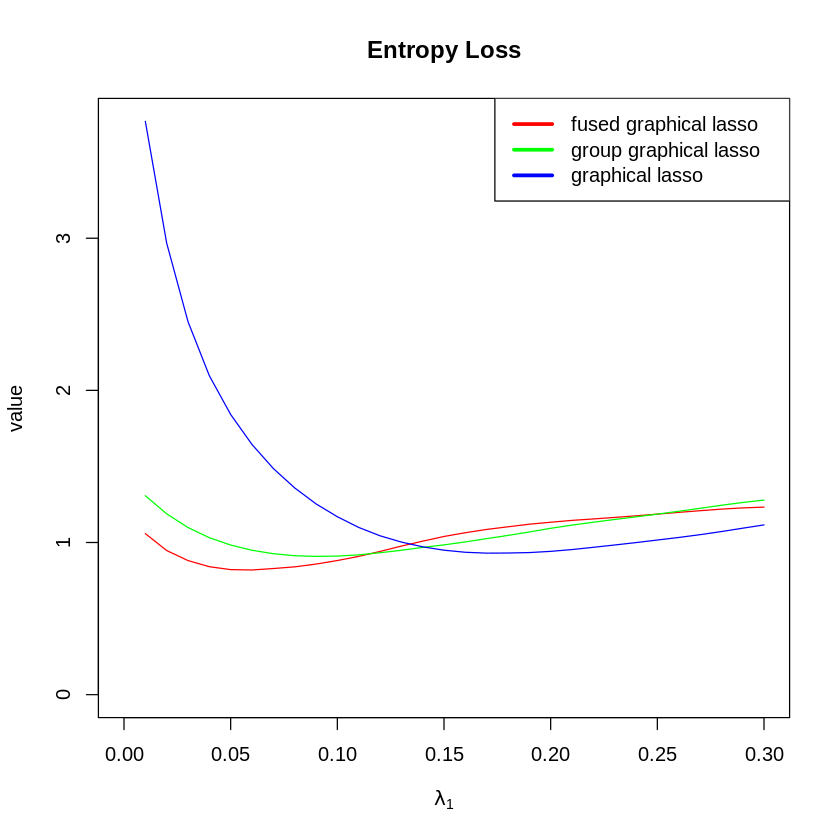

png 
  3

png 
  2

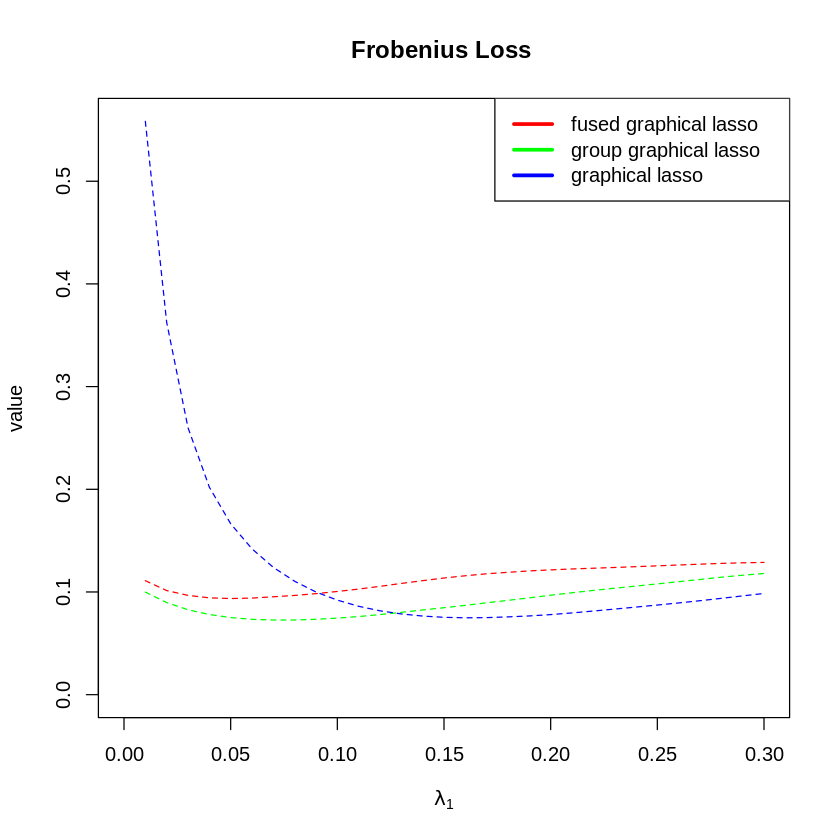

png 
  3

png 
  2

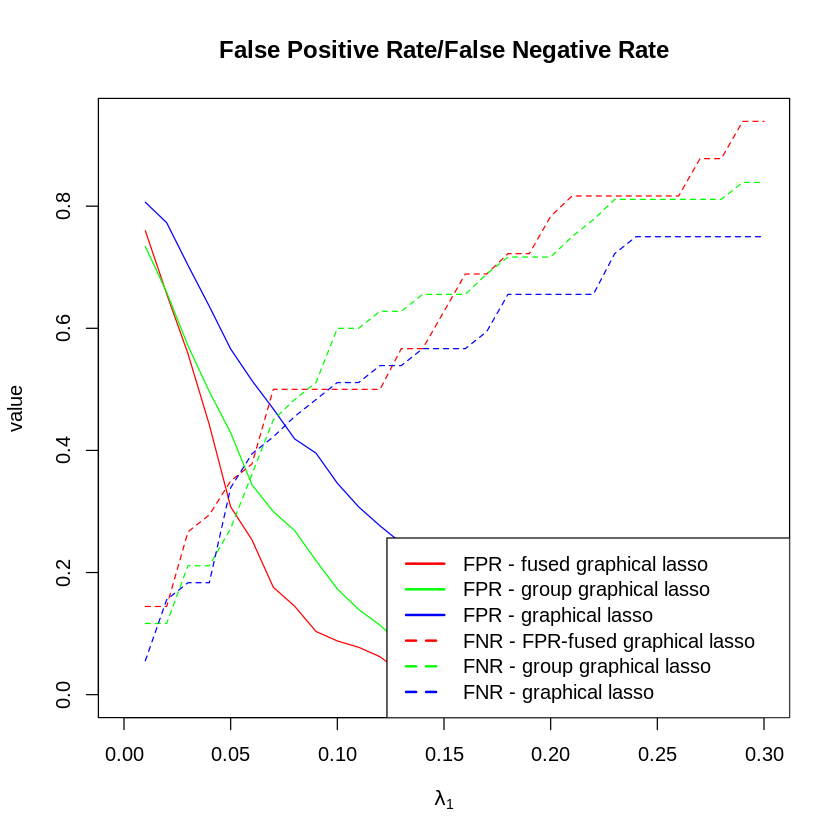

In [11]:
##########################
#    Entropy Loss        #
#                        #
##########################

cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.3),ylim = c(0,max(el_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="Entropy Loss")
lines(lambda.eff, el_vec[1,], col=cl[1], type="l") 
lines(lambda.eff, el_vec[2,], col=cl[2], type="l") 
lines(lambda.eff, el_vec[3,], col=cl[3], type="l") 

legend_txt <- c("fused graphical lasso","group graphical lasso","graphical lasso")
legend("topright", legend = legend_txt, col = cl, cex = 1, lwd = 3)
dev.copy(png, file=paste(path,ID,"_entropy_loss",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

############################
#    Frobenius Loss        #
#                          #
############################

cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.3),ylim = c(0,max(fr_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="Frobenius Loss ")
lines(lambda.eff, fr_vec[1,], col=cl[1], type="l",lty=2) 
lines(lambda.eff, fr_vec[2,], col=cl[2], type="l",lty=2) 
lines(lambda.eff, fr_vec[3,], col=cl[3], type="l",lty=2) 
legend_txt <- c("fused graphical lasso","group graphical lasso","graphical lasso")
legend("topright", legend = legend_txt, col = cl, cex = 1, lwd = 3)
dev.copy(png, file=paste(path,ID,"frobenius_loss",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

##########################
#          FPR,FNR       #
#                        #
##########################



cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.3),ylim = c(0,max(fnr_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="False Positive Rate/False Negative Rate")
lines(lambda.eff, fpr_vec[1,], col=cl[1], type="l") 
lines(lambda.eff, fpr_vec[2,], col=cl[2], type="l") 
lines(lambda.eff, fpr_vec[3,], col=cl[3], type="l") 
lines(lambda.eff, fnr_vec[1,], col=cl[1], type="l",lty=2) 
lines(lambda.eff, fnr_vec[2,], col=cl[2], type="l",lty=2) 
lines(lambda.eff, fnr_vec[3,], col=cl[3], type="l",lty=2) 
legend_txt <- c("FPR - fused graphical lasso","FPR - group graphical lasso","FPR - graphical lasso",
"FNR - FPR-fused graphical lasso","FNR - group graphical lasso","FNR - graphical lasso")
legend("bottomright", legend = legend_txt, col = cl, cex = 1, lwd = 2,lty=c(1,1,1,2,2,2))
dev.copy(png, file=paste(path,ID,"fpr_fnr",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

###  Akaike Information Criterion (AIC)
$vAIC(\lambda_1,\lambda_2)=\sum_{k=1}^K n_k tr(S^{(k)}\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2})-n_k\log\det\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}+2E_k$

$S^{(k)}$ is the sampled covariance of group $k$

$\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}$ is the estimated inverse covariance matrix under parameters $\lambda_1,\lambda_2$

$E_k$ is the number of nonzero elements in $\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}$

perform grid search tuning the parameters

In [12]:
###########################################
#       Parameter Selection               #
#       BIC                               #
###########################################
BIC <- function(X, est_graph){
    num <- length(X)
    BIC_acc <- 0.
    for(i in 1:num){
        
        data_num <- dim(X[[i]])[1]
        sample_cov <- cov(X[[i]], X[[i]])
        tr_sum <- sum(diag(sample_cov %*% est_graph$theta[[i]]))

        log_det <- determinant(est_graph$theta[[i]], logarithm = TRUE)$modulus[1][1]

        E <- sum(sum(est_graph$theta[[i]] != 0.))
        log_data <- c(data_num*(tr_sum - log_det) , E)
       # print(log_data)
        BIC_acc <- BIC_acc + (tr_sum - log_det) + E
    }
    return(BIC_acc)
}

In [13]:
###########################################
#       Parameter Selection               #
#       Cross Validation                  #
###########################################
convert2list <- function(X,len){
    new_list <- list()
    for (i in 1:len){
        new_matrix <- X[,,i]
        new_list[i] <- list(new_matrix)
    }
}
CV <- function(X, D, method="fused", lam1, lam2){
    num <- length(X)
    n <- dim(X[[1]])[1]
    p <- dim(X[[1]])[2]
    CV_acc <- 0.
    X_matrix <- array(unlist(X),dim=c(n,p,length(X)))
    d_size <- as.integer(floor(n/D))
    for (d in 0:(D-1)){
        if(d != (D-1)){
            X_d <- X_matrix[(d_size*d+1):(d_size*(d+1)),,] 
            X_nod <- abind(X_matrix[0:(d_size*d),,], X_matrix[(d_size*(d+1)+1):n,,], along=1)           
        }
        else{
            X_d <- X_matrix[(d_size*d+1):n,,] 
            X_nod <- X_matrix[0:(d_size*d),,]           
        }
        X_nod <- convert2list(X_nod,num)
        fit <- JGL(Y=X_nod, penalty=method, lambda1=lam1, lambda2=lam2, return.whole.theta=TRUE) 
        for(k in 1:num){
            sample_cov <- cov(X_d[,,k],X_d[,,k])
            tr_sum <- sum(diag(sample_cov %*% fit$theta[[i]]))
            log_det <- determinant(fit$theta[[i]], logarithm = TRUE)$modulus[1][1]
            CV_acc <- CV_acc + (tr_sum-log_det)
        }
    }
    return(CV_acc)
}

In [14]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
aic_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))

for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        aic_vec[i,j] <- vAIC(data, fit00)        
   }
}



png 
  3

png 
  2

[1] 6483.458

row,col
22,1


[1] "lambda_1 0.22"
[1] "lambda_2 0.01"


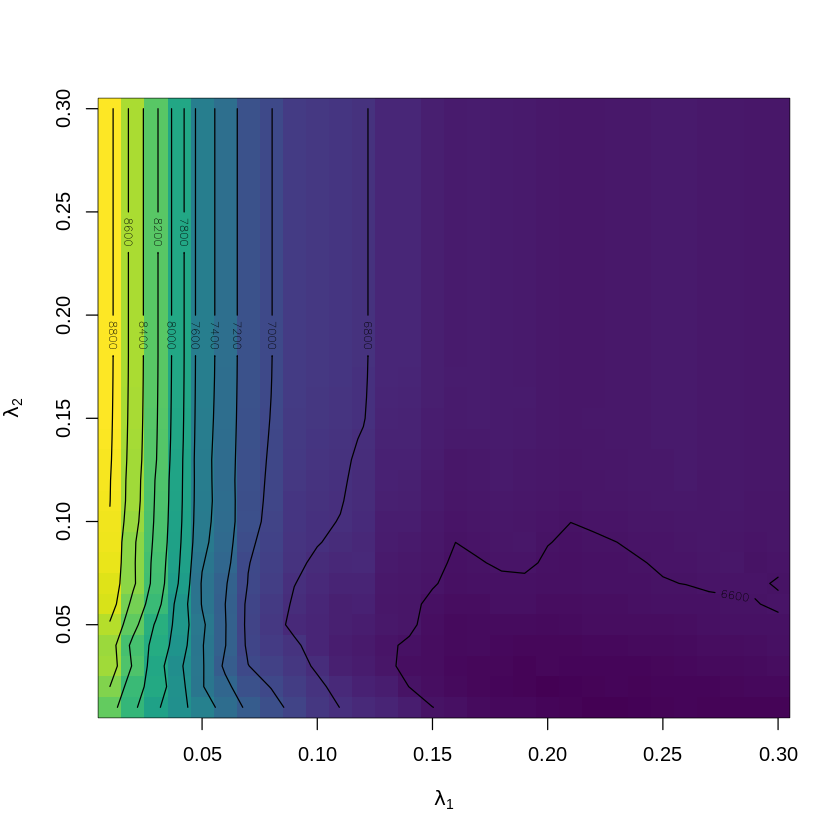

In [15]:
lambda.eff <- seq(0.01, 0.3, len = interval_l)
image(x=lambda.eff,y=lambda.eff,z=aic_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=lambda.eff,y=lambda.eff,z=aic_vec, add = TRUE,nlevels = 10)
dev.copy(png, file=paste(path,ID,"fgl_AIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()
i_idx <- which(aic_vec == min(aic_vec), arr.ind = TRUE)[1,1]
j_idx <- which(aic_vec == min(aic_vec), arr.ind = TRUE)[1,2]

min(aic_vec)
 which(aic_vec == min(aic_vec), arr.ind = TRUE)

lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))

In [16]:
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
bic_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        bic_vec[i,j] <- vBIC(data, fit00)        
    }

}

png 
  3

png 
  2

[1] 84.74244

row,col
30,1


[1] "lambda_1 0.3"
[1] "lambda_2 0.01"


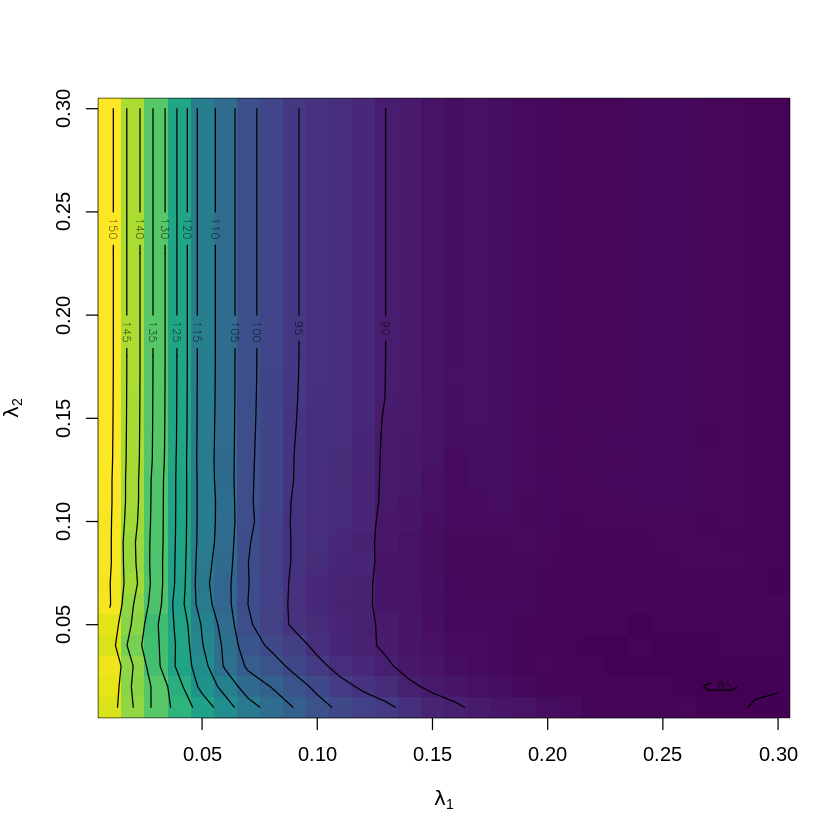

In [17]:
lambda.eff <- seq(0.01, 0.3, len = interval_l)
image(x=lambda.eff,y=lambda.eff,z=bic_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=lambda.eff,y=lambda.eff,z=bic_vec, add = TRUE,nlevels = 20)
dev.copy(png, file=paste(path,ID,"fgl_BIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()
i_idx <- which(bic_vec == min(bic_vec), arr.ind = TRUE)[1,1]
j_idx <- which(bic_vec == min(bic_vec), arr.ind = TRUE)[1,2]

min(bic_vec)
 which(bic_vec == min(bic_vec), arr.ind = TRUE)

lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))

#Note
#it seems like the AIC does not favor lamba_2

In [18]:
print("##################################################")
print("#    Fused Graphical Lasso (tuned parameters)    #")
print("##################################################")
print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
fgl_t.results=JGL(Y=data,penalty="fused",lambda1=lam_1,lambda2=lam_2, return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(fgl_t.results, graph, p, 2)))
print(paste("Average frobenious loss:", frobenious_loss(fgl_t.results, graph, 2)))
print(paste("Average false positive rate:", avg_fprfnr(fgl_t.results, graph, 2)[1]))
print(paste("Average false negative rate:", avg_fprfnr(fgl_t.results, graph, 2)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
#show_result(fgl_t.results, graph, 4, method="fgl_tuned_001_BIC")

[1] "##################################################"
[1] "#    Fused Graphical Lasso (tuned parameters)    #"
[1] "##################################################"
[1] "lambda_1 0.3"
[1] "lambda_2 0.01"
[1] "Average entropy loss: 1.10698034753346"
[1] "Average frobenious loss: 0.102610600013825"
[1] "Average false positive rate: 0.00516826923076923"
[1] "Average false negative rate: 0.811111111111111"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"


In [19]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
aic_g_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        aic_g_vec[i,j] <- vAIC(data, fit00)        
    }

}

png 
  3

png 
  2

[1] 6479.927

[1] "lambda_1 0.23"
[1] "lambda_2 0.03"


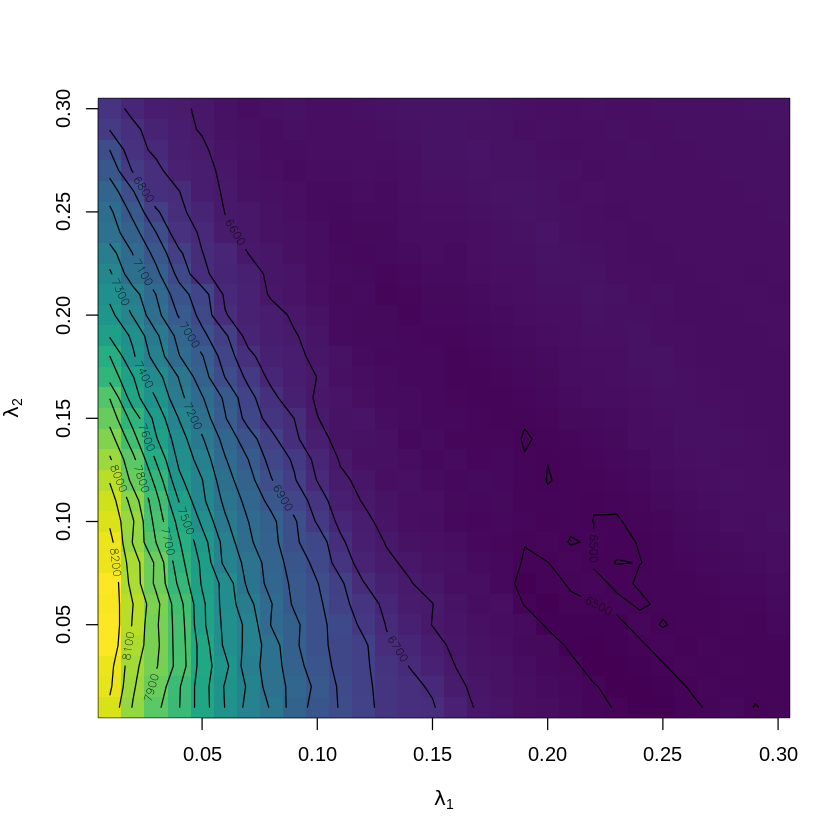

In [20]:
###########################################
#         group graphical lasso           #
###########################################
lambda.eff <- seq(0.01, 0.3, len = interval_l)

image(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=aic_g_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=aic_g_vec, add = TRUE,nlevels = 20)
dev.copy(png, file=paste(path,"ggl_AIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()
#axis(1, at = seq(0.01, 0.5, by = 0.01))
#axis(2, at = seq(0.01, 0.5, by = 0.01))

#heatmap(aic_vec, scale = "row",xlab=TeX('$\\lambda_1$'))
i_idx <- which(aic_g_vec == min(aic_g_vec), arr.ind = TRUE)[1]
j_idx <- which(aic_g_vec == min(aic_g_vec), arr.ind = TRUE)[2]

min(aic_g_vec)


lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))

[1] "##################################################"
[1] "#    Group Graphical Lasso (tuned parameters)    #"
[1] "##################################################"
[1] "lambda_1 0.23"
[1] "lambda_2 0.03"
[1] "Average entropy loss: 0.934793191135093"
[1] "Average frobenious loss: 0.0802889028103252"
[1] "Average false positive rate: 0.0220565558288407"
[1] "Average false negative rate: 0.753676470588235"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"
[1] "visualize estimated graph 1"
[1] "False Negative Rate: 0.6"
[1] "False Positive Rate: 0.0307692307692308"
[1] "Sensitivity 0.0266666666666667"
[1] "visualize estimated graph 2"
[1] "False Negative Rate: 0.833333333333333"
[1] "False Positive Rate: 0.0260416666666667"
[1] "Sensitivity 0.00925925925925926"


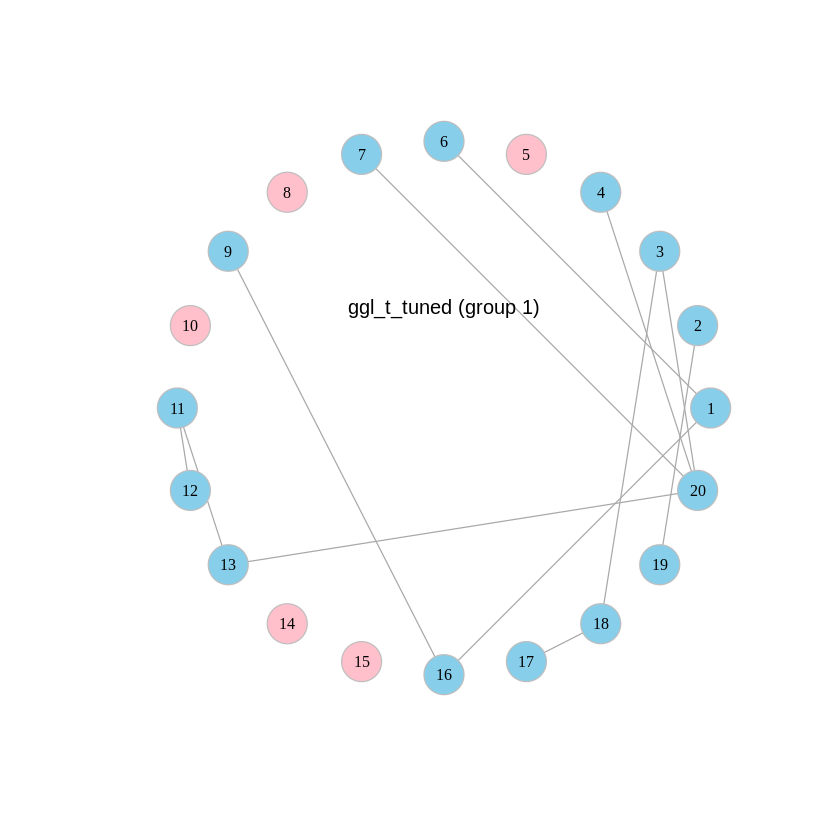

[1] "visualize estimated graph 3"
[1] "False Negative Rate: 0.75"
[1] "False Positive Rate: 0.0210526315789474"
[1] "Sensitivity 0.0125"


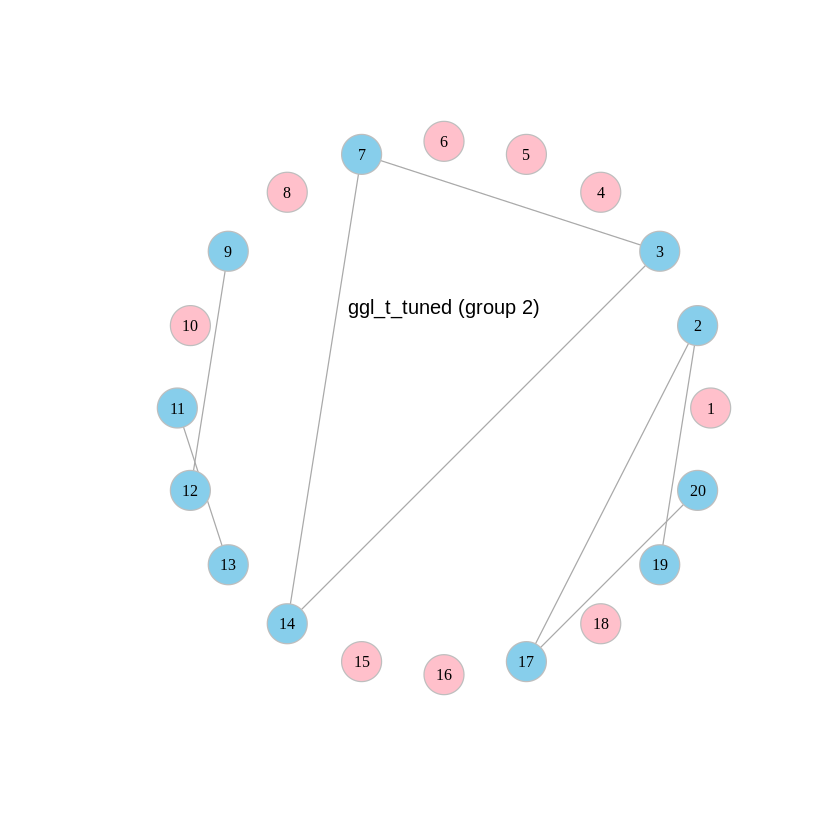

[1] "visualize estimated graph 4"
[1] "False Negative Rate: 0.764705882352941"
[1] "False Positive Rate: 0.0103626943005181"
[1] "Sensitivity 0.013840830449827"


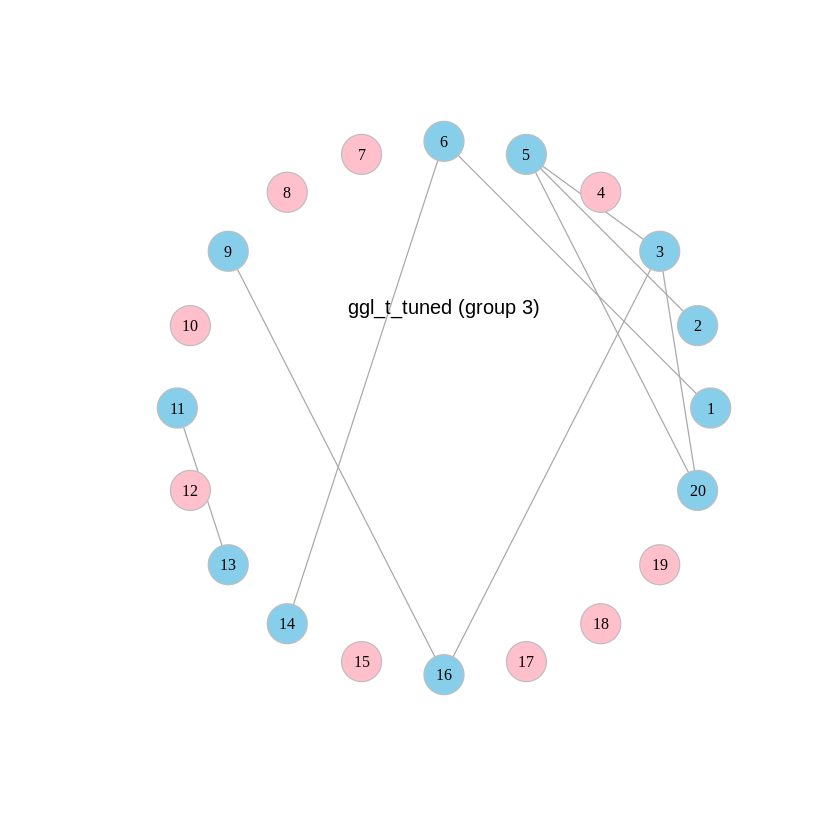

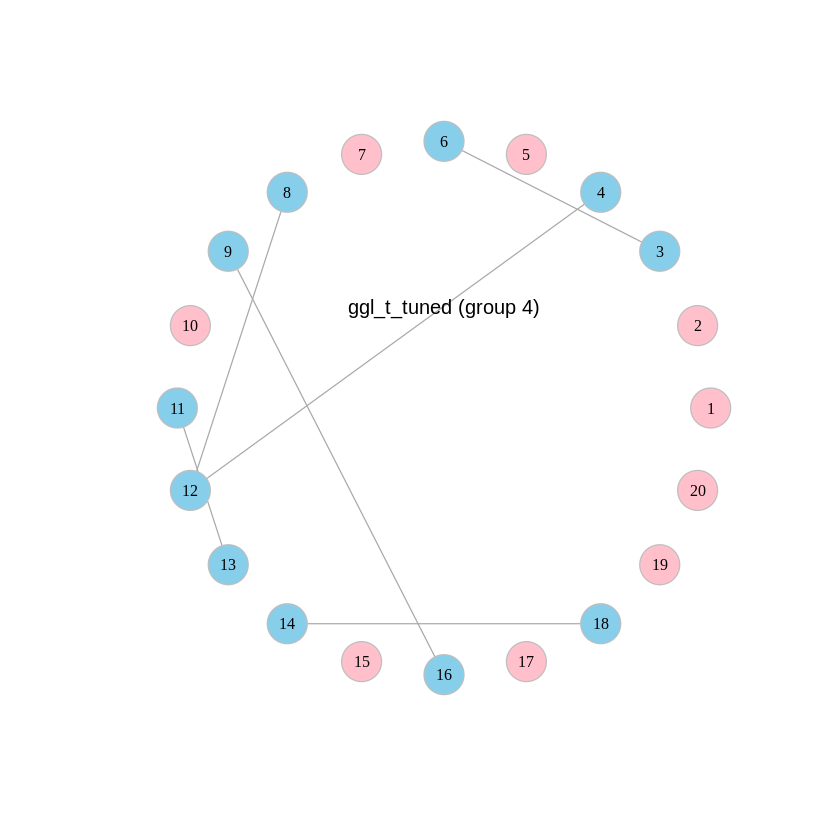

In [21]:


print("##################################################")
print("#    Group Graphical Lasso (tuned parameters)    #")
print("##################################################")
print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
ggl_t.results=JGL(Y=data,penalty="group",lambda1=lam_1,lambda2=lam_2, return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(ggl_t.results, graph, p, 4)))
print(paste("Average frobenious loss:", frobenious_loss(ggl_t.results, graph, 4)))
print(paste("Average false positive rate:", avg_fprfnr(ggl_t.results, graph, 4)[1]))
print(paste("Average false negative rate:", avg_fprfnr(ggl_t.results, graph, 4)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
show_result(ggl_t.results, graph, 4, method="ggl_t_tuned")


In [22]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 50
lambda.eff <- seq(0.01, 1., len = interval_l)
aic_gl_vec <- rep(NA, length(lambda.eff))
for(i in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=0., return.whole.theta=TRUE) 
        aic_gl_vec[i] <- vAIC(data, fit00)        

}

In [23]:
###########################################
#             graphical lasso             #
###########################################

#image(z=aic_gl_vec, col=viridis(256),xlab=TeX('$\\lambda_1$'))
#dev.copy(png, file=paste(path,"gl_AIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
#dev.off()

i_idx <- which.min(aic_gl_vec) 

lam_1 <- lambda.eff[i_idx]

print(paste("optimal lambda_1", lam_1))

[1] "optimal lambda_1 0.252448979591837"


[1] "##################################################"
[1] "#       Graphical Lasso (tuned parameters)      #"
[1] "##################################################"
[1] "optimal lambda_1 0.252448979591837"
[1] "Average entropy loss: 0.934793191135093"
[1] "Average frobenious loss: 0.0795161503343788"
[1] "Average false positive rate: 0.0246744286358583"
[1] "Average false negative rate: 0.753676470588235"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"
[1] "visualize estimated graph 1"
[1] "False Negative Rate: 0.666666666666667"
[1] "False Positive Rate: 0.0307692307692308"
[1] "Sensitivity 0.0222222222222222"
[1] "visualize estimated graph 2"
[1] "False Negative Rate: 0.833333333333333"
[1] "False Positive Rate: 0.03125"
[1] "Sensitivity 0.00925925925925926"


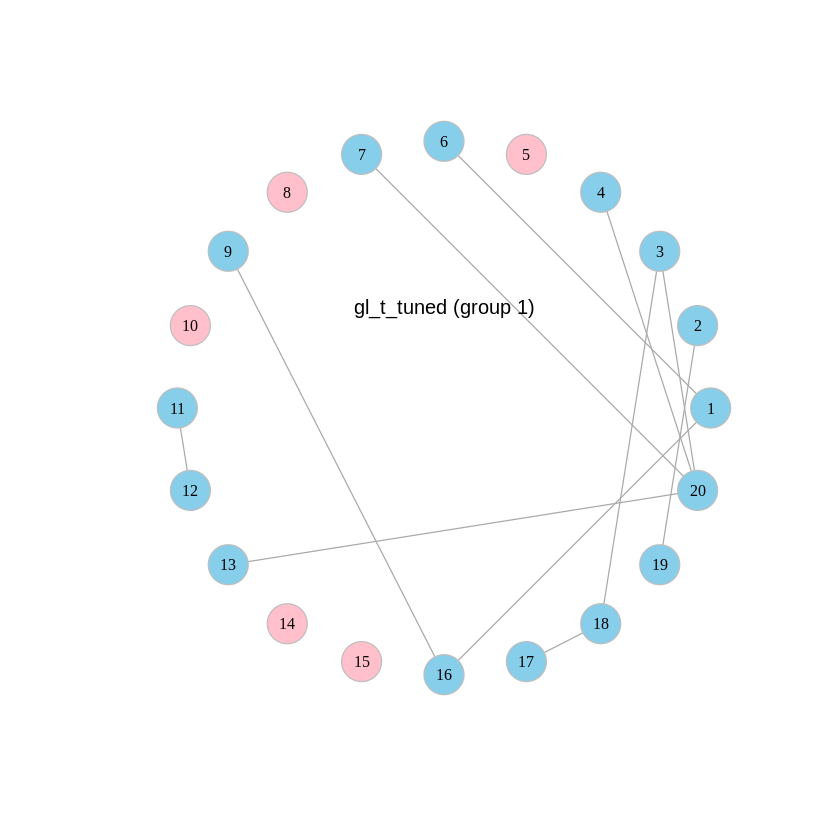

[1] "visualize estimated graph 3"
[1] "False Negative Rate: 0.75"
[1] "False Positive Rate: 0.0263157894736842"
[1] "Sensitivity 0.0125"


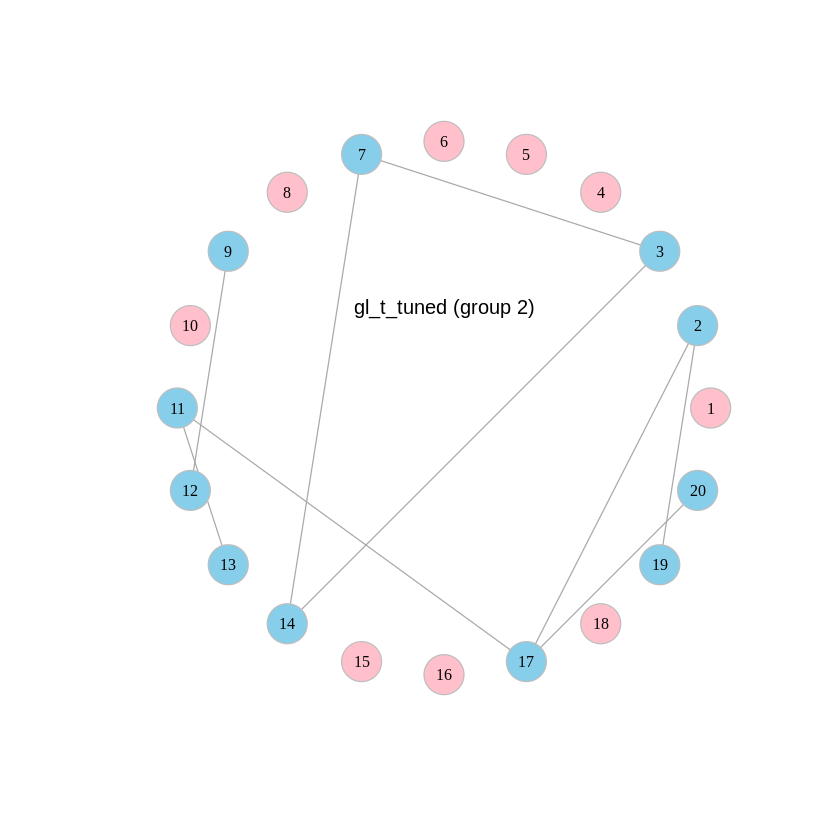

[1] "visualize estimated graph 4"
[1] "False Negative Rate: 0.764705882352941"
[1] "False Positive Rate: 0.0103626943005181"
[1] "Sensitivity 0.013840830449827"


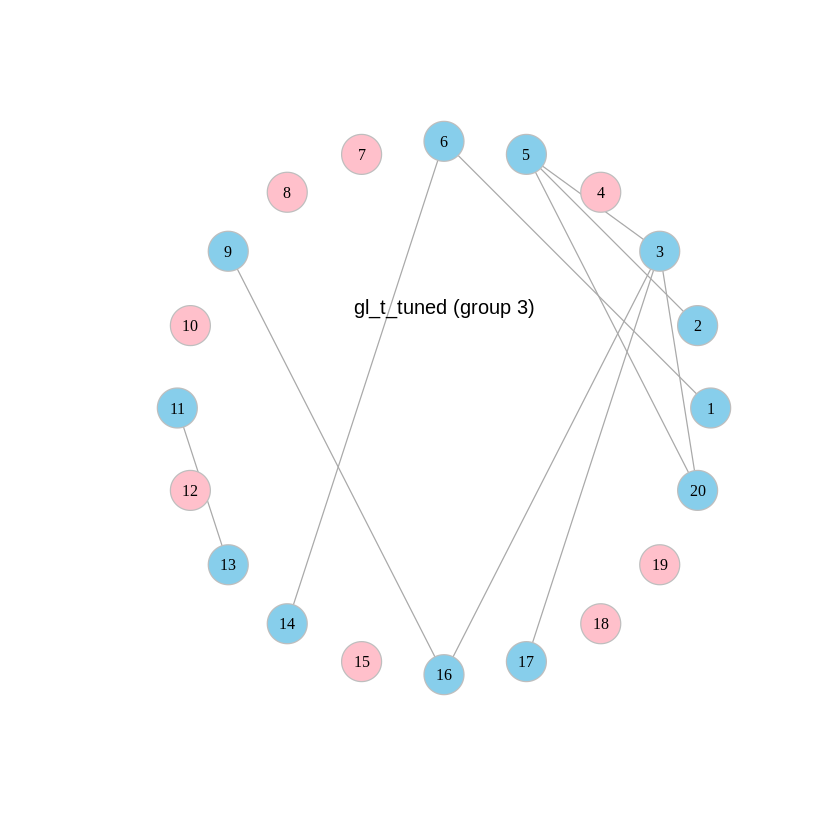

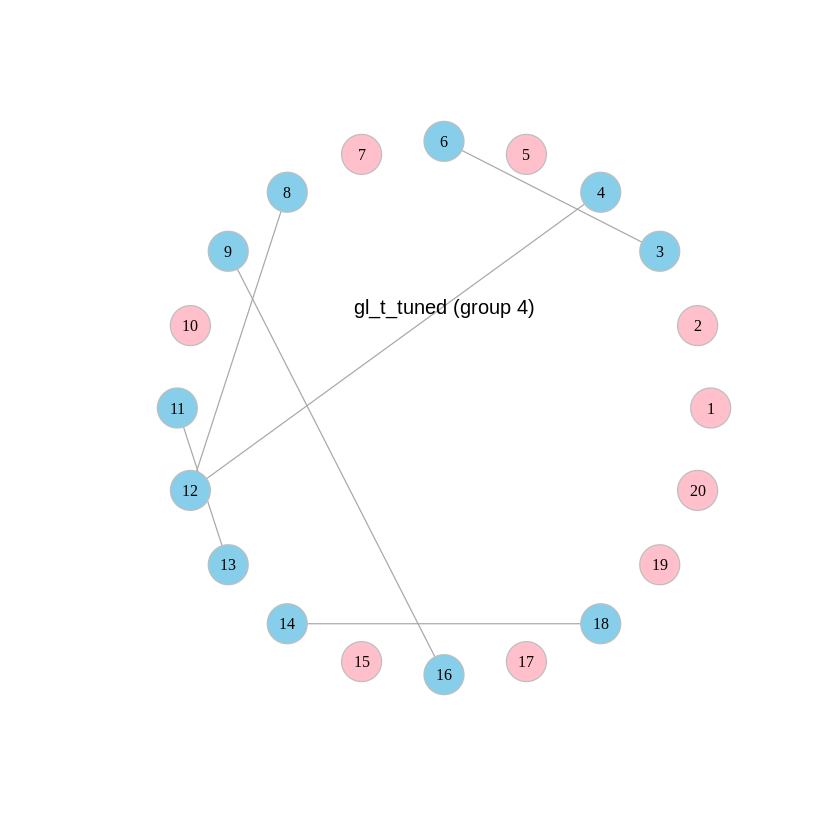

In [24]:
print("##################################################")
print("#       Graphical Lasso (tuned parameters)      #")
print("##################################################")
print(paste("optimal lambda_1", lam_1))
gl_t.results=JGL(Y=data,penalty="fused",lambda1=lam_1,lambda2=0., return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(ggl_t.results, graph, p, 4)))
print(paste("Average frobenious loss:", frobenious_loss(gl_t.results, graph, 4)))
print(paste("Average false positive rate:", avg_fprfnr(gl_t.results, graph, 4)[1]))
print(paste("Average false negative rate:", avg_fprfnr(gl_t.results, graph, 4)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
show_result(gl_t.results, graph, 4, method="gl_t_tuned")